In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import data_process as dp
import matplotlib.pyplot as plt
import DLEDMD
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import models

In [2]:
import DLEDMD_eig

In [3]:
# load data
sTrain=np.load('./tem_data/v3/sTrain.npy',allow_pickle=True)
cTrain=np.load('./tem_data/v3/cTrain.npy',allow_pickle=True)
iTrain=np.load('./tem_data/v3/iTrain.npy',allow_pickle=True)
oTrain=np.load('./tem_data/v3/oTrain.npy',allow_pickle=True)
oTrain_out=np.load('./tem_data/v3/oTrain_out.npy',allow_pickle=True)
sTest=np.load('./tem_data/v3/sTest.npy',allow_pickle=True)

HRT=84 # time=7 hour, equal to 84 steps
outstep=6 # predict 30 min, equal to 6 steps
n=sTest.shape[0]

In [4]:
params = {
            's_input_shape': sTrain.shape[1], 
            'c_input_shape': cTrain.shape[1], 
            'i_input_shape': iTrain.shape[1],
            'o_input_shape': oTrain.shape[1],
            'snet_layer': 3,
            's_net': [{'num': 50}, {'num': 50}, {'num': 50}],
            'cnet_layer': 3,
            'c_net': [{'num': 50}, {'num': 50}, {'num': 50}],
            'inet_layer': 3,
            'i_net': [{'num': 50}, {'num': 50},  {'num': 50}],
            'Encoding_layer': 4,
            'Encoding_param': [{'num': 50} for _ in range(4)],
            'Output_layer': 6,
            'Output_param': [{'num': 50} for _ in range(5)] + [{'num': oTrain_out.shape[1]}],
            'training_data_num': n-outstep-HRT-10
        }

In [5]:
mmd='DLEDMD_net'
inlr=1e-4
model=DLEDMD.DLEDMD_net(params)
model.build_net(inlr)
model.model = models.load_model('./Results/DLEDMD_net/model/v3/model_v3_450.h5')

e:\anaconda3\envs\tensorflow-cpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
cmodel=DLEDMD_eig.DLEDMD_net(params)
cmodel.build_net(inlr)

In [7]:
for i in range(len(cmodel.model.layers)):
    for j in range(len(model.model.layers)):
        if cmodel.model.layers[i].name==model.model.layers[j].name:
            cmodel.model.layers[i]=model.model.layers[j]

# Get K

In [8]:
# load data
sTrain=np.load('./tem_data/v3/sTrain.npy',allow_pickle=True)
cTrain=np.load('./tem_data/v3/cTrain.npy',allow_pickle=True)
iTrain=np.load('./tem_data/v3/iTrain.npy',allow_pickle=True)
oTrain=np.load('./tem_data/v3/oTrain.npy',allow_pickle=True)
oTrain_out=np.load('./tem_data/v3/oTrain_out.npy',allow_pickle=True)

sVal=np.load('./tem_data/v3/sVal.npy',allow_pickle=True)
cVal=np.load('./tem_data/v3/cVal.npy',allow_pickle=True)
iVal=np.load('./tem_data/v3/iVal.npy',allow_pickle=True)
oVal=np.load('./tem_data/v3/oVal.npy',allow_pickle=True)
oVal_out=np.load('./tem_data/v3/oVal_out.npy',allow_pickle=True)

sTest=np.load('./tem_data/v3/sTest.npy',allow_pickle=True)
cTest=np.load('./tem_data/v3/cTest.npy',allow_pickle=True)
iTest=np.load('./tem_data/v3/iTest.npy',allow_pickle=True)
oTest=np.load('./tem_data/v3/oTest.npy',allow_pickle=True)
oTest_out=np.load('./tem_data/v3/oTest_out.npy',allow_pickle=True)

In [9]:
faiX=cmodel.model.predict([sTest[0:4000],cTest[0:4000],iTest[0:4000],oTest[0:4000]])
faiY=cmodel.model.predict([sTest[10:4010],cTest[10:4010],iTest[10:4010],oTest[10:4010]])

e:\anaconda3\envs\tensorflow-cpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [10]:
Gu = faiX.T.dot(faiX)/faiX.shape[0]
Au = faiX.T.dot(faiY)/faiX.shape[0]
K = np.linalg.pinv(Gu+0.00001*np.eye(Gu.shape[0])).dot(Au)

In [11]:
S,U=np.linalg.eig(K)
u,s,v=np.linalg.svd(K)

In [12]:
eig_data=[]
for ei in S:
    eig_data.append([np.real(ei),np.imag(ei)])
eig_data=np.array(eig_data)

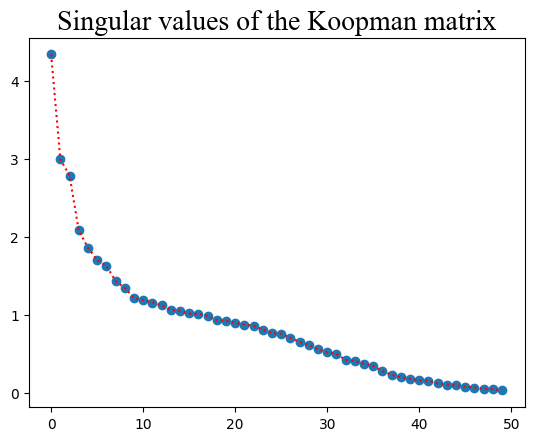

In [13]:
font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,}

plt.scatter([i for i in range(s.shape[0])],s)
plt.plot(s,'r:')
plt.title('Singular values of the Koopman matrix',font1)
plt.savefig('6.3-singular.png', bbox_inches='tight', dpi=500)   

e:\anaconda3\envs\tensorflow-cpu\lib\site-packages\matplotlib\collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
e:\anaconda3\envs\tensorflow-cpu\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


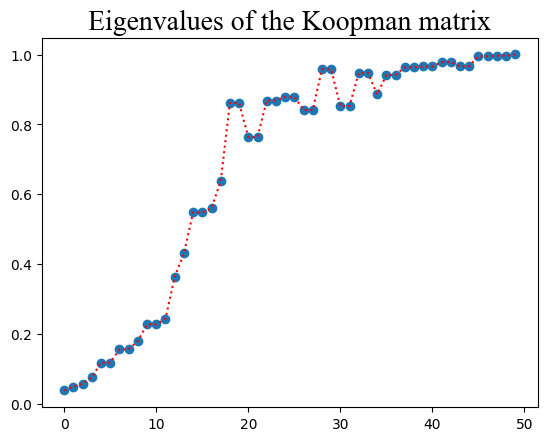

In [14]:
font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,}

plt.scatter([i for i in range(S.shape[0])],S)
plt.plot(S,'r:')
plt.title('Eigenvalues of the Koopman matrix',font1)
plt.savefig('6.3-eigular.png', bbox_inches='tight', dpi=500)  

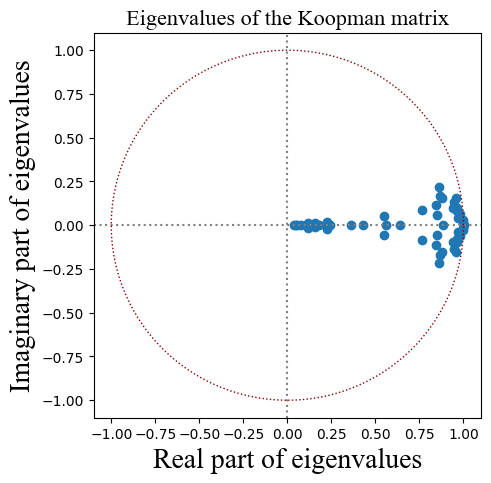

In [15]:
font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,}

font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 16,}

fig = plt.figure(figsize=(5,5))
it=0

axes=fig.add_subplot(1,1,1)
axes.scatter(eig_data[:,0],eig_data[:,1])
axes.axhline(y=0,ls=":",c="grey")#添加水平直线
axes.axvline(x=0,ls=":",c="grey")#添加水平直线
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)
y = np.sin(theta)
axes.plot(x, y, color="darkred", linewidth=1,linestyle=':')
plt.xlabel('Real part of eigenvalues',font1)
plt.ylabel('Imaginary part of eigenvalues',font1)
axes.set_title('Eigenvalues of the DLEDMD',font2)


plt.savefig('6.3-eigenvalues.png', bbox_inches='tight', dpi=500)   

# Draw Matrix

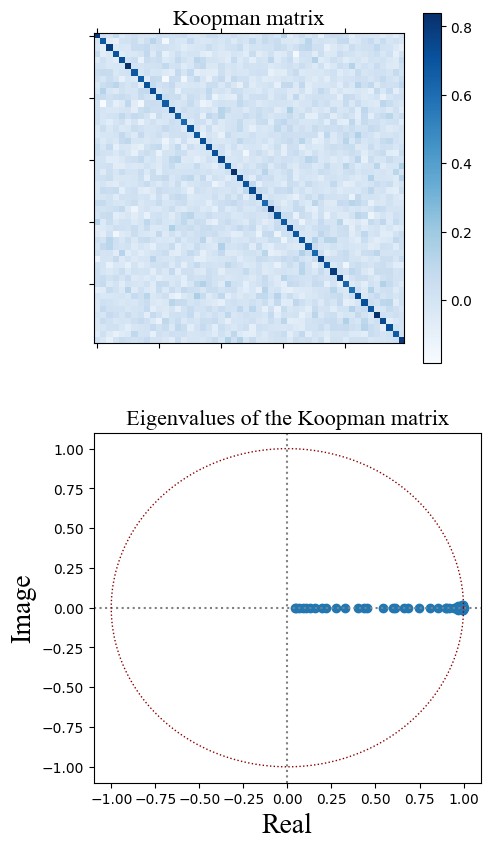

In [37]:
font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,}

font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 16,}

fig = plt.figure(figsize=(5,10))
it=0

axes=fig.add_subplot(2,1,1)
ax=axes.matshow(K,cmap=plt.cm.Blues)
axes.set_xticklabels([])
axes.set_yticklabels([])
plt.colorbar(ax)
axes.set_title('Koopman matrix',font2)

axes=fig.add_subplot(2,1,2)
axes.scatter(eig_data[:,0],eig_data[:,1])
axes.axhline(y=0,ls=":",c="grey")#添加水平直线
axes.axvline(x=0,ls=":",c="grey")#添加水平直线
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)
y = np.sin(theta)
axes.plot(x, y, color="darkred", linewidth=1,linestyle=':')
plt.xlabel('Real',font1)
plt.ylabel('Image',font1)
axes.set_title('Eigenvalues of the Koopman matrix',font2)


plt.savefig('6.3-eigenvalues.png', bbox_inches='tight', dpi=500)   

# Draw singular fig

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 4 array(s), for inputs ['s_input', 'c_input', 'i_input', 'o_output'] but instead got the following list of 1 arrays: [array([[0.],
       [0.],
       [0.],
       [0.]])]...

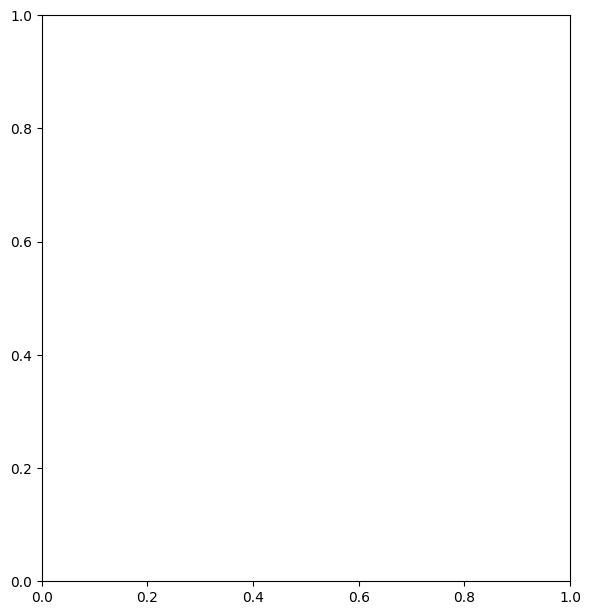

In [40]:
k=0

font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 30,}

font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 25,}


fig = plt.figure(figsize=(15,25))
it=0


for j in range(3):
    for i in range(2):
        axes=fig.add_subplot(3,2,it+1)
        it=it+1
        results=[]
        for ix in np.arange(0,10,0.05):
            line_R=[]
            for jx in np.arange(0,10,0.05):
                xt=[[ix,jx,0,0]]
                tem=[[0 for it in range(9)]]
                #x=np.array(xt+tem)
                #line.append(x.dot(u[1,:]))
                faix=cmodel.model.predict([sTest,cTest,iTest,oTest])
                line_R.append(v[:,it-1].dot(faix.T)[0])
            results.append(line_R)
        results=np.array(results)
        rt=np.zeros(results.shape)
        L=results.shape[0]-1
        for line in np.arange(rt.shape[0]):
            rt[line,:]=results[L-line,:]
        ax=axes.matshow(rt)
        plt.xticks([0,200],['0','10'],fontsize=15)
        plt.yticks([0,200],['10','0'],fontsize=15)
        plt.xlabel('$s_{1}$',fontdict=font2)
        plt.ylabel('$s_{2}$',fontdict=font2)
        plt.title('$\lambda$='+"%.2f"% s[it-1],fontdict=font1)
        cb=plt.colorbar(ax)
        cb.ax.tick_params(labelsize=20)  #设置色标刻度字体大小。
    k=k+1
    
fig.savefig('6.3-sig_fun.png', bbox_inches='tight', dpi=500)  

# Draw eigenfunction fig

In [14]:
Uinv=np.linalg.inv(U)

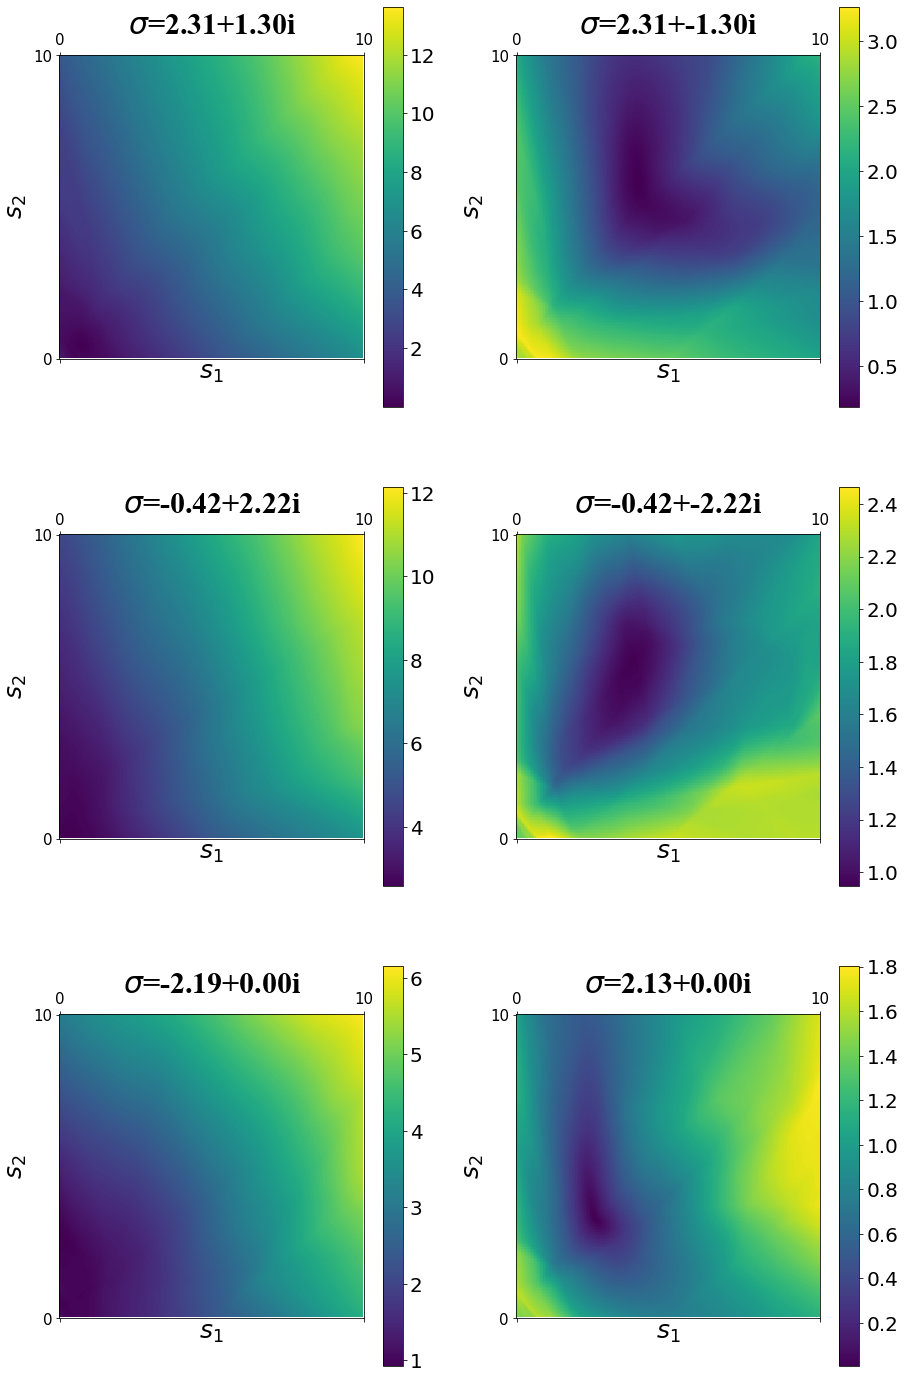

In [22]:
k=0

font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 30,}

font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 25,}

#EIGF=Uinv.dot()

fig = plt.figure(figsize=(15,25))
it=0
for j in range(3):
    for i in range(2):
        axes=fig.add_subplot(3,2,it+1)
        it=it+1
        results=[]
        for ix in np.arange(0,10,0.05):
            line_R=[]
            for jx in np.arange(0,10,0.05):
                xt=[[ix,jx,0,0]]
                tem=[[0 for it in range(9)]]
                #x=np.array(xt+tem)
                #line.append(x.dot(u[1,:]))
                faix=sess.run(model.faix,feed_dict={model.x:xt,model.f:tem})
                #line_R.append(np.abs(faix.dot(U[:,it])[0]))
                line_R.append(np.abs(Uinv[:,it].dot(faix.T)[0]))
            results.append(line_R)
        results=np.array(results)
        rt=np.zeros(results.shape)
        L=results.shape[0]-1
        for line in np.arange(rt.shape[0]):
            rt[line,:]=results[L-line,:]
        ax=axes.matshow(rt)
        plt.xticks([0,200],['0','10'],fontsize=15)
        plt.yticks([0,200],['10','0'],fontsize=15)
        plt.xlabel('$s_{1}$',fontdict=font2)
        plt.ylabel('$s_{2}$',fontdict=font2)
        plt.title('$\sigma$='+"%.2f"% eig_data[it-1][0]+'+'+"%.2f"% eig_data[it-1][1]+'i',fontdict=font1)
        #plt.colorbar(ax)
        cb=plt.colorbar(ax)
        cb.ax.tick_params(labelsize=20)  #设置色标刻度字体大小。
        
    k=k+1
    
fig.savefig('6.3-eig_fun.png', bbox_inches='tight', dpi=500)  

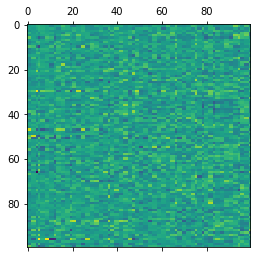

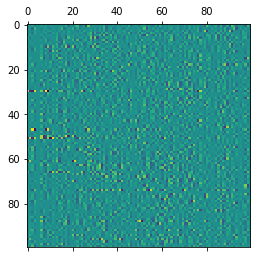

In [16]:
plt.matshow(U.real)
plt.matshow(U.imag)